Data Science Solutions with Python by Tshepo Chris Nokeri, Apress. 2021

# CHAPTER 8: CLUSTER ANALYSIS WITH SCIKIT-LEARN, PYSPARK, AND H2O

This chapter executes and appraises the K-Means method using a diverse set of comprehensive Python frameworks (i.e., SciKit-Learn, PySpark, and H2O). At the outset, it sufficiently clarifies the underlying concept behind the distance estimation.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set("talk","ticks",font_scale=1,font="Calibri")
from pylab import rcParams
plt.rcParams["figure.dpi"] = 300
df = pd.read_csv(r"C:\Users\i5 lenov\Documents\MLAgortihms\Datasets\Mall_Customers.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [2]:
drop_column_names = df.columns[[0, 1]]
initial_data = df.drop(drop_column_names, axis="columns")

## Data Preprocessing

In [3]:
from sklearn.preprocessing import StandardScaler
sk_standard_scaler = StandardScaler()
sk_standard_scaled_data = sk_standard_scaler.fit_transform(initial_data)

In [4]:
from sklearn.decomposition import PCA
sk_principal_component_method = PCA(n_components=3)
sk_principal_component_method.fit(sk_standard_scaled_data)
sk_principal_component_method_transformed_data = sk_principal_component_method.transform(sk_standard_scaled_data)

## Elbow Curve

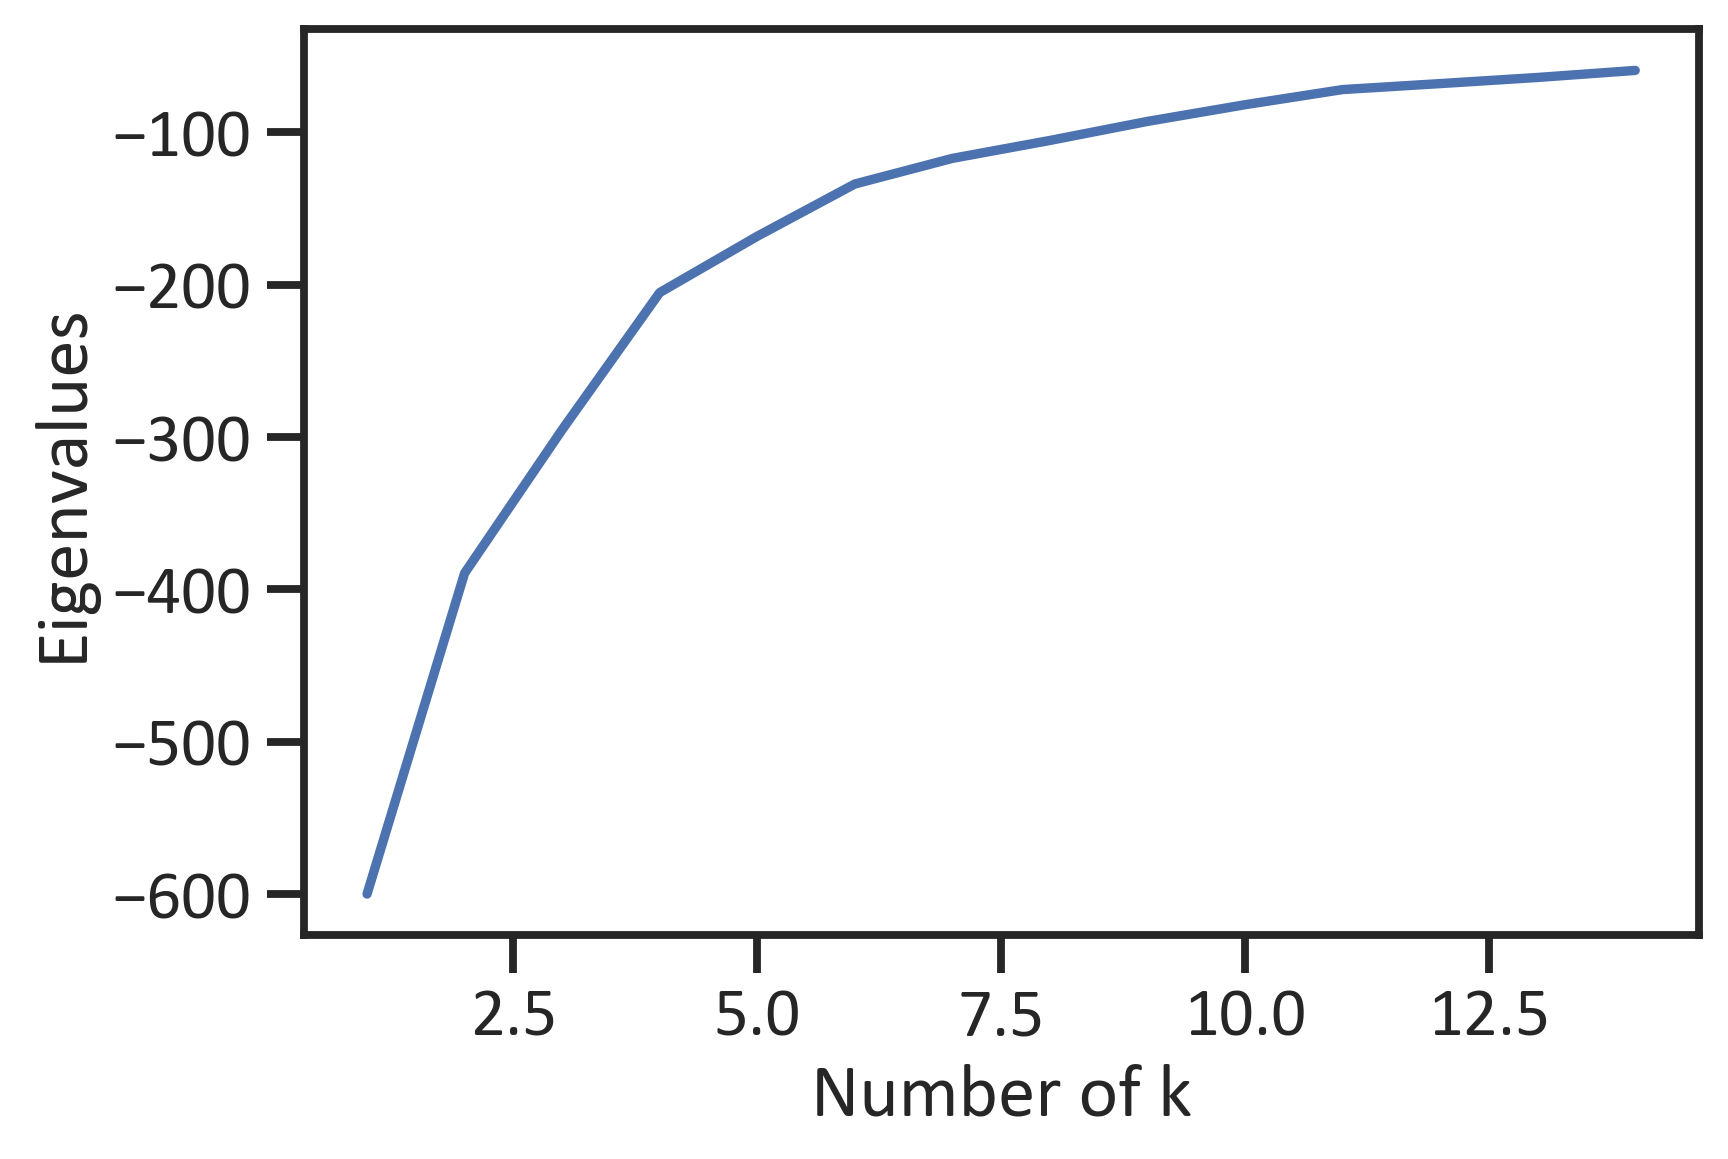

In [5]:
from sklearn.cluster import KMeans
elbow_range = range(1, 15)
sk_kmeans_method = [KMeans(n_clusters=x) for x in elbow_range]
sk_kmeans_method_score = [sk_kmeans_method[x].fit(sk_principal_component_method_transformed_data).score(sk_principal_component_method_transformed_data) for x in range(len(sk_kmeans_method))]
plt.plot(elbow_range, sk_kmeans_method_score)
plt.xlabel("Number of k")
plt.ylabel("Eigenvalues")
plt.show()

# SciKit-Learn in Action

In [6]:
sk_kmeans_method = KMeans(n_clusters=3)
sk_kmeans_method_fitted = sk_kmeans_method.fit(sk_standard_scaled_data)

In [7]:
sk_kmeans_method_labels = pd.DataFrame(sk_kmeans_method_fitted.labels_, columns = ["Labels"])

In [8]:
sk_kmeans_method_centers = sk_kmeans_method_fitted.cluster_centers_
sk_kmeans_method_centers = pd.DataFrame(sk_kmeans_method_centers, columns = ("1st center","2nd center","3rd center"))
sk_kmeans_method_centers_mean = pd.DataFrame(sk_kmeans_method_centers.mean())
sk_kmeans_method_centers_std = pd.DataFrame(sk_kmeans_method_centers.std())
sk_kmeans_method_centers_mean_std = pd.concat([sk_kmeans_method_centers_mean, sk_kmeans_method_centers_std], axis=1)
sk_kmeans_method_centers_mean_std.columns =["Center mean", "Center standard deviation"]
sk_kmeans_method_centers_mean_std

,Center mean,Center standard deviation
1st center,-0.157489,0.942836
2nd center,0.129950,0.854012
3rd center,0.222984,0.891719


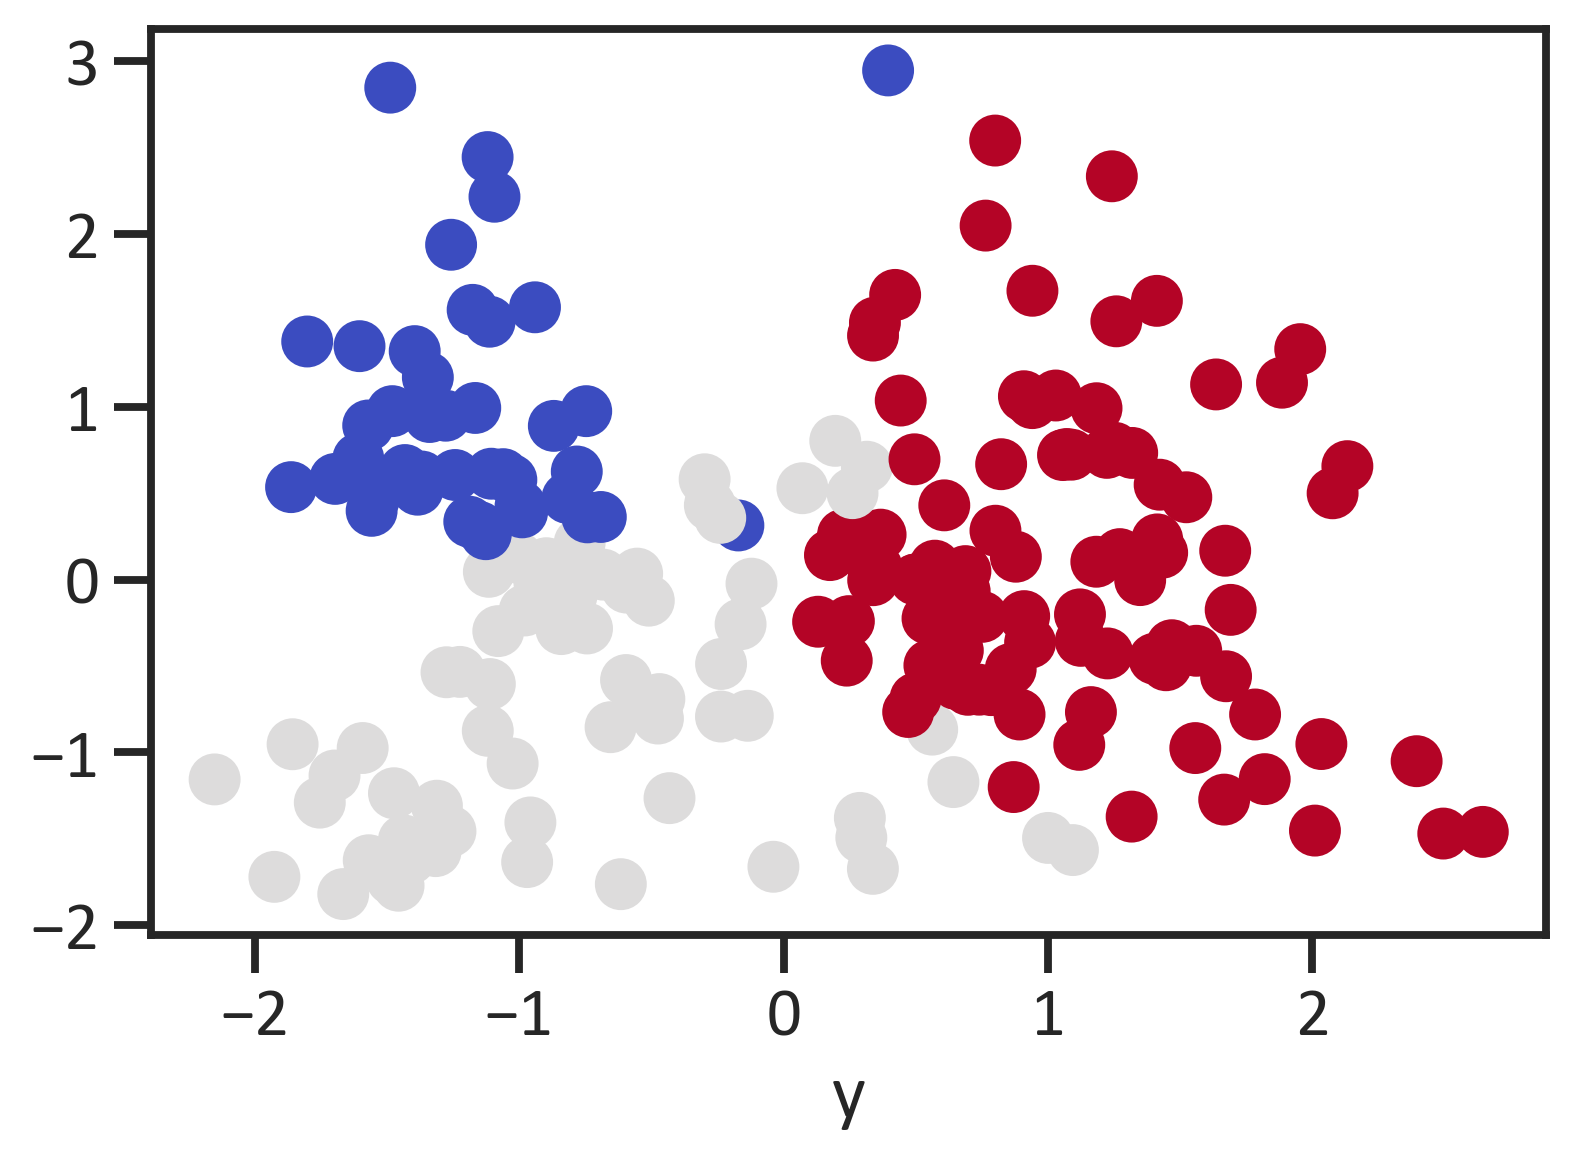

In [9]:
plt.scatter(sk_principal_component_method_transformed_data[:,0], sk_principal_component_method_transformed_data[:, 1], 
            c=sk_kmeans_method_fitted.labels_,cmap="coolwarm", s=120)
plt.xlabel("y")
plt.show()

# PySpark in Action

In [10]:
import findspark as initiate_pyspark
initiate_pyspark.init("C:\Spark\spark-3.0.0-bin-hadoop2.7")

In [11]:
from pyspark import SparkConf
pyspark_configuration = SparkConf().setAppName("pyspark_kmeans_method").setMaster("local")

In [12]:
from pyspark import SparkContext
pyspark_context = SparkContext(conf=pyspark_configuration)

In [13]:
from pyspark.sql import SparkSession
pyspark_session = SparkSession(pyspark_context)

In [14]:
pyspark_initial_data = pyspark_session.createDataFrame(initial_data)
pyspark_initial_data = pyspark_initial_data.na.drop()

In [15]:
x_list = list(initial_data.iloc[::, 0:3].columns)
from pyspark.ml.feature import VectorAssembler
pyspark_data_columns = x_list
pyspark_vector_assembler = VectorAssembler(inputCols=pyspark_data_columns, outputCol="features")
pyspark_data = pyspark_vector_assembler.transform(pyspark_initial_data)

In [16]:
from pyspark.ml.clustering import KMeans
pyspark_kmeans_method = KMeans().setK(3).setSeed(1)
pyspark_kmeans_method_fitted = pyspark_kmeans_method.fit(pyspark_data)

In [17]:
pyspark_yhat = pyspark_kmeans_method_fitted.transform(pyspark_data)
pyspark_yhat_pandas_df = pyspark_yhat.toPandas()

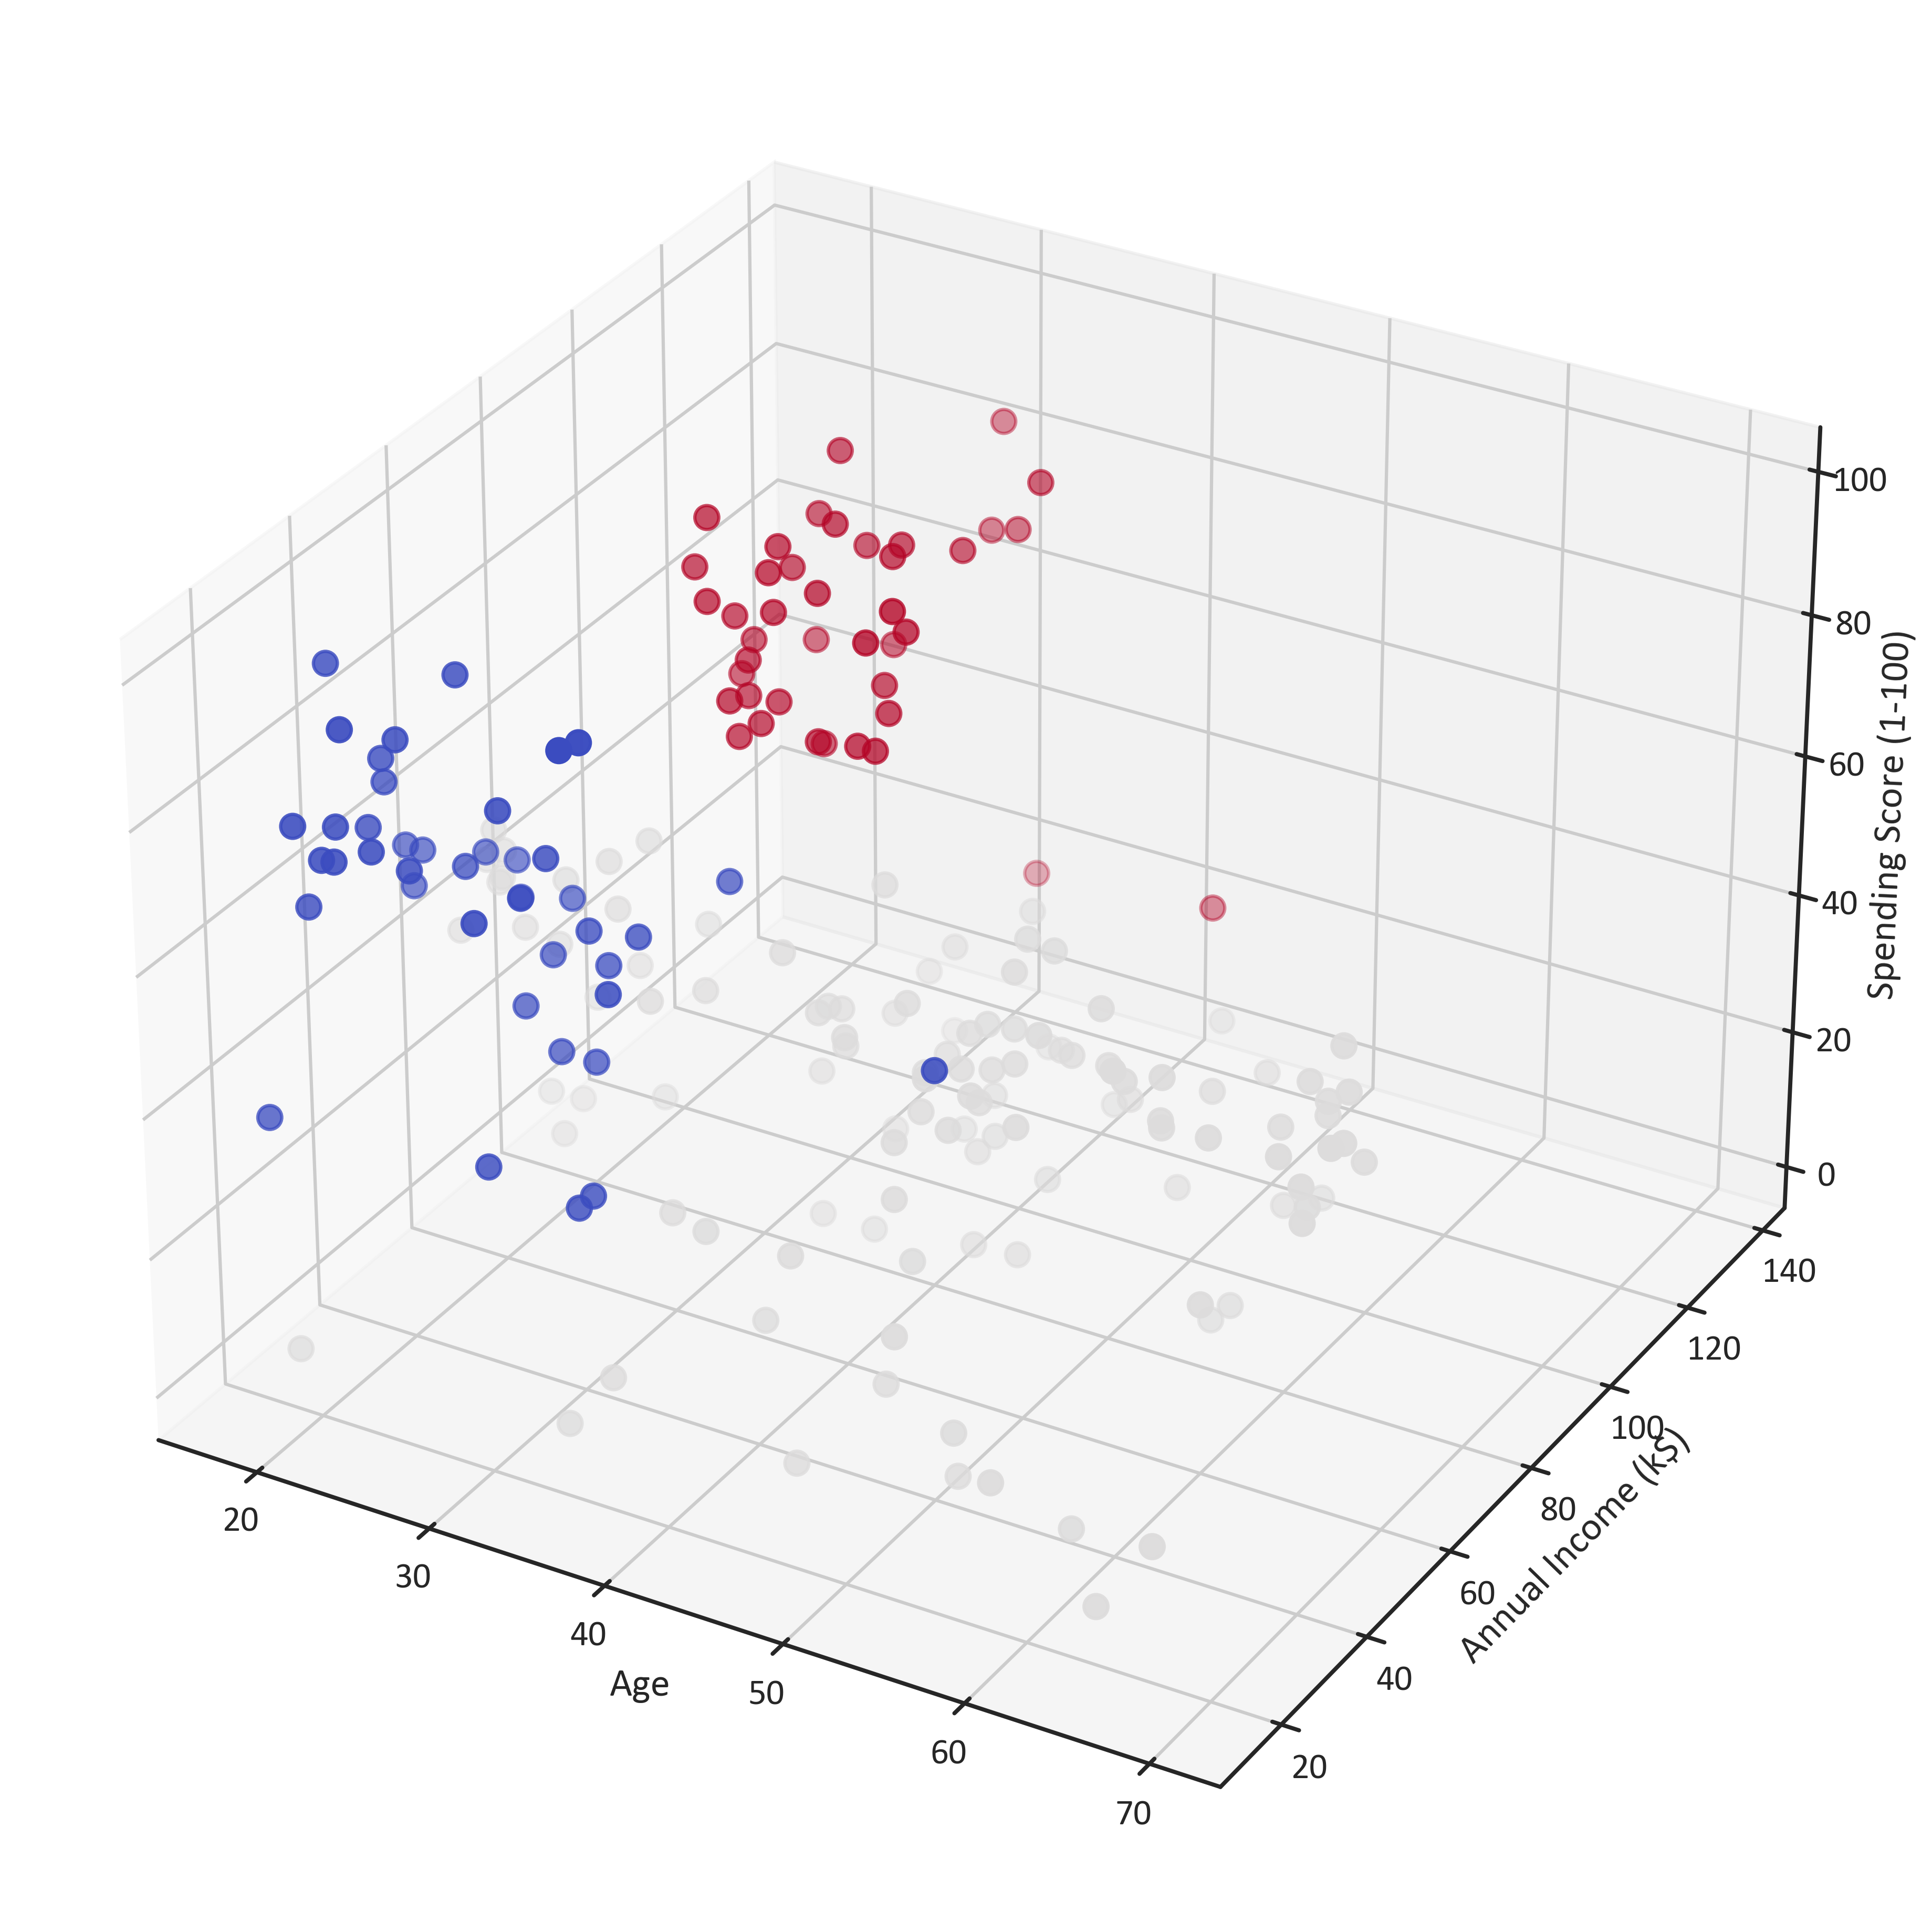

In [18]:
from mpl_toolkits.mplot3d import Axes3D
figure = plt.figure(figsize=(12, 12))
ax = Axes3D(figure)
ax.scatter(pyspark_yhat_pandas_df.iloc[::, 0],
           pyspark_yhat_pandas_df.iloc[::, 1],
           pyspark_yhat_pandas_df.iloc[::, 2],
           c = pyspark_yhat_pandas_df.iloc[::, 4],
           cmap = "coolwarm",
           s = 120)
ax.set_xlabel(initial_data.columns[0])
ax.set_ylabel(initial_data.columns[1])
ax.set_zlabel(initial_data.columns[2])
figure.show()

In [19]:
pyspark_kmeans_method_centers = pyspark_kmeans_method_fitted.clusterCenters()
print("K-Means method cluster centers")
for pyspark_cluster_center in pyspark_kmeans_method_centers:
    print(pyspark_cluster_center)

K-Means method cluster centers
[26.5952381  33.14285714 65.66666667]
[45.30769231 60.52991453 34.47008547]
[32.97560976 88.73170732 79.24390244]


In [20]:
from pyspark.ml.evaluation import ClusteringEvaluator
pyspark_kmeans_method_assessment = ClusteringEvaluator()
pyspark_kmeans_method_silhoutte = pyspark_kmeans_method_assessment.evaluate(pyspark_yhat)
print("Silhouette score = " + str(pyspark_kmeans_method_silhoutte))

Silhouette score = 0.45097978411312134


# H2O in  Action

In [21]:
import h2o as initialize_h2o
initialize_h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM (build 11.0.6+8-b765.1, mixed mode)
  Starting server from C:\Users\i5 lenov\AppData\Roaming\Python\Python37\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\I5LENO~1\AppData\Local\Temp\tmprf9cdsfi
  JVM stdout: C:\Users\I5LENO~1\AppData\Local\Temp\tmprf9cdsfi\h2o_i5_lenov_started_from_python.out
  JVM stderr: C:\Users\I5LENO~1\AppData\Local\Temp\tmprf9cdsfi\h2o_i5_lenov_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Africa/Harare
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.7
H2O_cluster_version_age:,"1 year, 1 month and 2 days !!!"
H2O_cluster_name:,H2O_from_python_i5_lenov_3hcz5c
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.975 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


In [22]:
h2o_data = initialize_h2o.H2OFrame(initial_data)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [23]:
h2o_training_data, h2o_validation_data = h2o_data.split_frame(ratios=[.8])

In [24]:
from h2o.estimators import H2OKMeansEstimator
h2o_kmeans_method = H2OKMeansEstimator(k=3)
h2o_kmeans_method.train(x = x_list, training_frame = h2o_training_data, validation_frame = h2o_validation_data)

kmeans Model Build progress: |████████████████████████████████████████████| 100%


In [25]:
h2o_yhat = h2o_kmeans_method.predict(h2o_validation_data)

kmeans prediction progress: |█████████████████████████████████████████████| 100%


In [26]:
h2o_kmeans_method_assessment = h2o_kmeans_method.model_performance()
h2o_kmeans_method_assessment


ModelMetricsClustering: kmeans
** Reported on train data. **

MSE: NaN
RMSE: NaN
Total Within Cluster Sum of Square Error: 212.53416045513404
Total Sum of Square Error to Grand Mean: 453.00000529466104
Between Cluster Sum of Square Error: 240.465844839527

Centroid Statistics: 


,,centroid,size,within_cluster_sum_of_squares
0,,1.0,68.0,109.634033
1,,2.0,36.0,40.305408
2,,3.0,48.0,62.594720
